# EXPLORING THE MIMIC-III DATABASE
Note: this dataset is open-source, but restricted access. You must request access via https://mimic.physionet.org/gettingstarted/access/. I downloaded the dataset onto my personal computer and ran the analyses locally. Given HIPAA and privacy considerations, I will only show summary plots from data in the database (no patient-specific information will be displayed).

I'm first loading in the PATIENTS, ADMISSIONS, ICUSTAYS, and PRESCRIPTIONS databases, then performing some simple conversions and calculations, and then merging the datasets.

Ultimately, I wanted to look at the relationship between a number of factors and the timing of transfer to the ICU relative to hospital admission.

In [10]:
import pandas as pd

In [11]:
#1. Load patients
# import patient info
data_dir = 'data/physionet.org/files/mimiciii/1.4/'
patient_file = 'PATIENTS.csv'
df_patients = pd.read_csv(data_dir + patient_file)

In [12]:
df_patients=df_patients.drop(['ROW_ID','DOD','DOD_HOSP','DOD_SSN','EXPIRE_FLAG'],axis=1)

In [13]:
# convert date strings to datetime
df_patients.DOB = pd.to_datetime(df_patients.DOB,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [14]:
# import admissions info
admissions_file = 'ADMISSIONS.csv'
df_admissions = pd.read_csv(data_dir + admissions_file)

In [15]:
# removing data columns that won't be used for predicting ICU stays
df_admissions = df_admissions.drop(['ROW_ID','HOSPITAL_EXPIRE_FLAG','DEATHTIME','DISCHARGE_LOCATION','EDREGTIME','EDOUTTIME'],axis=1)

In [16]:
# convert time strings to datetime
df_admissions.ADMITTIME = pd.to_datetime(df_admissions.ADMITTIME,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_admissions.DISCHTIME = pd.to_datetime(df_admissions.DISCHTIME,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [17]:
# combining ethnicities into uber-categories for simplicity
ethnicites_dict = {
    'WHITE': ['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - BRAZILIAN', 'PORTUGUESE'],
'BLACK': ['BLACK/AFRICAN AMERICAN', 'BLACK/AFRICAN', 'BLACK/HAITIAN', 'BLACK/CAPE VERDEAN'],
'UNKNOWN': ['UNKNOWN/NOT SPECIFIED','PATIENT DECLINED TO ANSWER', 'UNABLE TO OBTAIN'],
'ASIAN': ['ASIAN', 'ASIAN - CHINESE', 'ASIAN - VIETNAMESE', 'ASIAN - CAMBODIAN', 'ASIAN - FILIPINO', 'ASIAN - KOREAN', 'ASIAN - THAI', 'ASIAN - JAPANESE', 'ASIAN - OTHER'],
'INDIAN': ['ASIAN - ASIAN INDIAN'],
'OTHER': ['OTHER','SOUTH AMERICAN', 'CARIBBEAN ISLAND'],
'HISPANIC/LATINO': ['HISPANIC OR LATINO', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - COLOMBIAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - MEXICAN'],
'MULTIRACE': ['MULTI RACE ETHNICITY'],
'MIDDLE EASTERN': ['MIDDLE EASTERN'],
'AMERICAN NATIVE': ['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER']
}

def replace_ethval_todictval(x,ethnicites_dict):
    for key,val in ethnicites_dict.items():
        if x in val:
            return key

In [18]:
# replace each ETHNICITY entry in df by its associated simple-form ethnicity (i.e., associated key in ethnicites_dict)
df_admissions['ETHNICITY'] = df_admissions['ETHNICITY'].apply(replace_ethval_todictval,args=(ethnicites_dict,))
df_admissions['ETHNICITY'].unique()

array(['WHITE', 'UNKNOWN', 'MULTIRACE', 'BLACK', 'HISPANIC/LATINO',
       'ASIAN', 'OTHER', 'AMERICAN NATIVE', 'INDIAN', 'MIDDLE EASTERN'],
      dtype=object)

In [19]:
# calculate length of hospital stay
df_admissions['HOSPITAL_DAYS'] = (df_admissions['DISCHTIME'] - df_admissions['ADMITTIME']).dt.total_seconds()/(24*60*60)
# negative admit days = dead on arrival, remove
doa_idx = df_admissions[df_admissions['HOSPITAL_DAYS']<0].index
df_admissions = df_admissions.drop(doa_idx,axis=0)

In [1]:
# merge patient and admissions df
df_patient_admit = df_patients.merge(df_admissions,how='left',left_on=['SUBJECT_ID'],right_on=['SUBJECT_ID'])

NameError: name 'df_patients' is not defined

In [21]:
# calculate age at admit
df_patient_admit['ADMIT_AGE'] = df_patient_admit['ADMITTIME'].dt.year - df_patient_admit['DOB'].dt.year
# no longer need DOB, remove
df_patient_admit=df_patient_admit.drop(['DOB'],axis=1)

In [22]:
# 2. Remove patients <age
# not necessary, but if wanted to limit analysis to non-neonatal issues
age = 1
child_idx = df_patient_admit[df_patient_admit['ADMIT_AGE']<age].index
child_patients = df_patient_admit.iloc[child_idx]['SUBJECT_ID'].unique()
df_patient_admit = df_patient_admit.drop(child_idx, axis=0)

# convert ages >200 to nan because these ages are obscured (purposefully to prevent PHI from being released)
# contrary to newborns, we want to keep these patients in the dataset, but will simply lose age as a predictor
from numpy import nan
df_patient_admit.loc[df_patient_admit['ADMIT_AGE']>200,'ADMIT_AGE'] = nan

In [23]:
# 3. Load icustays
# import icu stays info
icustays_file = 'ICUSTAYS.csv'
df_icustays = pd.read_csv(data_dir + icustays_file)

child_idx = df_icustays[df_icustays['SUBJECT_ID'].isin(child_patients)].index
df_icustays = df_icustays.drop(child_idx,axis=0)

# first & last care units/ward ids and out times are for ICU stays themselves and therefore will not be helpful in predicting ICU stays
df_icustays = df_icustays.drop(['ROW_ID','FIRST_CAREUNIT','LAST_CAREUNIT','FIRST_WARDID','LAST_WARDID','OUTTIME','LOS'],axis=1)

# convert time strings to datetime
df_icustays.INTIME = pd.to_datetime(df_icustays.INTIME,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [24]:
# join patients, admissions, and icustays
df_patient_admit_icu = df_patient_admit.merge(df_icustays,how='left',left_on=['SUBJECT_ID','HADM_ID'],right_on=['SUBJECT_ID','HADM_ID'])

In [25]:
# calculate days from hospital admission to icu admission
df_patient_admit_icu['DAYS_ADM_TO_ICU'] = (df_patient_admit_icu['INTIME'] - df_patient_admit_icu['ADMITTIME']).dt.total_seconds()/(24*60*60)

In [26]:
# drop time columns no longer needed
df_patient_admit_icu = df_patient_admit_icu.drop(['DISCHTIME','INTIME'],axis=1)

In [27]:
# logical for whether patients were admitted to ICU within 24 hours of hospital admission
df_patient_admit_icu['SAMEDAY_ADM_TO_ICU'] = df_patient_admit_icu['DAYS_ADM_TO_ICU'].apply(lambda x: int(x<=1))

In [28]:
# clean up diagnoses
df_patient_admit_icu['DIAGNOSIS'] = df_patient_admit_icu['DIAGNOSIS'].str.strip()

import re
all_diagnoses = []

# 1. save "raw" diagnoses from df to map back to later
diagnoses_raw = df_patient_admit_icu['DIAGNOSIS'].dropna().tolist()

# 2. create a "split" diagnoses list of lists that is a 1-to-1 match to "raw"
diagnoses_split = [re.split(';|,',x) for x in diagnoses_raw]

# 3. use "split" diagnosis to get list of "unique diagnoses"
all_diagnoses = [d for sublist in diagnoses_split for d in sublist]
# strip again in case splitting led to leading whitespaces
all_diagnoses = [d.strip() for d in all_diagnoses]

unique_diagnoses = list(set(all_diagnoses))
unique_diagnoses.pop(unique_diagnoses.index('')) # first entry is empty ('')

# 5. create 'clean' unique diagnoses that fix data by removing non-alphanumeric characters appropriately
# remove these characters first and replace with whitespace as these are consistently used to separate terms
unique_diagnoses_clean = [re.sub(r'[\\\|/.-]+', ' ', i) for i in unique_diagnoses]

# remove any other non-alphanumerics entirely as these are typically erroneous
unique_diagnoses_clean = [re.sub(r'[^a-zA-Z\d\s ]', '', i) for i in unique_diagnoses_clean]

In [29]:
# import necessary packages for next steps
from fuzzywuzzy import fuzz, process
from collections import Counter 

In [30]:
def create_diagnosis_dict(diagn_clean,diagn_raw,thresh):
    # this function creates a dictionary that matches the 'raw' form of each diagnosis with a list of the most-common
    # similar diagnosis words across all diagnoses. each 'raw' diagnosis is a key in the dictionary and the associated
    # value is a list of portions of the 'raw' diagnosis that are common across other diagnoses that have a similar
    # tokens based on the token_set_ratio score from fuzzywuzzy.
    
    diagnoses_dict = dict()
    for ix,diagnosis in enumerate(diagn_clean):
        try:
            diagn_tup = process.extractBests(diagnosis,diagn_clean[ix+1:],scorer=fuzz.token_set_ratio,score_cutoff=thresh,limit=200)
        except:
            diagn_tup = [('',0)]

        similar_diagns = [item[0] for item in diagn_tup] # these are all the similar diagnoses to diagnosis

        # set up to be able to use Counter
        # this keeps similar diagnoses phrases grouped together
        similar_diagns_flat = ','.join(similar_diagns)
        similar_diagns_flat = similar_diagns_flat.split(',')
        # this splits common diagnoses into single words
#         similar_diagns_flat = ' '.join(similar_diagns)
#         similar_diagns_flat = similar_diagns_flat.split()

        # identify most common word
        if len(similar_diagns_flat)>0: # only run if there is something in similar_diags_flat
            # find raw diagnoses that are associated with similar_diagns
            indices = [i for i,x in enumerate(diagn_clean) for item in similar_diagns_flat if x == item]
            similar_diagns_raw = [diagn_raw[i] for i in indices]
            
            counter = Counter(similar_diagns_flat)
            most_common = counter.most_common(1)
            one_word_diagn = most_common[0][0].strip()
            
            if len(one_word_diagn)>1: # remove single-letter diagnoses because they provide no information
                for sim_diagn in similar_diagns_raw:
                    if sim_diagn in diagnoses_dict.keys():
                        diagnoses_dict[sim_diagn].append(one_word_diagn)
                    else:
                        diagnoses_dict[sim_diagn] = [one_word_diagn]
            else:
                for sim_diagn in similar_diagns_raw:
                    if sim_diagn not in diagnoses_dict.keys():
                        diagnoses_dict[sim_diagn] = []
                    
    # remove duplicate most common diagnoses for each raw diagnosis
    for key in diagnoses_dict.keys():
        diagnoses_dict[key] = list(set(diagnoses_dict[key]))
        
    # add any raw diagnoses that are not in dict, but associate them with clean version
    for ix,diagnosis in enumerate(diagn_raw):
        if diagnosis not in diagnoses_dict.keys():
            diagnoses_dict[diagnosis] = [diagn_clean[ix]]
    
    return diagnoses_dict

In [31]:
# 5. for each unique diagnosis, find 'most-common' diagnoses based on similarity metric
# 6. find out which lists in "split" diagnosis list have that unique diagnosis
# 7. create dict that matches "raw" diagnosis to growing list of 'most-common' diagnoses
diagnoses_dict = create_diagnosis_dict(unique_diagnoses_clean,unique_diagnoses,90)

In [32]:
def replace_diagnosis_with_list(x,diag_dict):
    # this function will be used with df.apply to replace diagnosis term in 
    # dataframe with list of diagnoses that refer to that row
    
    if x in diag_dict.keys():
        x = diag_dict[x]
        
    return x

In [33]:
# 8. replace each "raw" diagnoses in df by its associated list of 'most-common' diagnoses
df_patient_admit_icu['DIAGNOSIS'] = df_patient_admit_icu['DIAGNOSIS'].apply(replace_diagnosis_with_list,args=(diagnoses_dict,))

for ix,val in enumerate(df_patient_admit_icu['DIAGNOSIS']):
    if type(val)==str and len(val): # if not-empty str, it was not in diagnoses_dict, and hence unchanged from original dataframe, want to change to list
        ix2 = diagnoses_raw.index(val)
        df_patient_admit_icu['DIAGNOSIS'].iloc[ix] = diagnoses_split[ix2]

/Users/adamgifford/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [34]:
# convert NaNs in DIAGNOSIS column to empty list
for row in df_patient_admit_icu.loc[df_patient_admit_icu.DIAGNOSIS.isnull(), 'DIAGNOSIS'].index:
    df_patient_admit_icu.at[row, 'DIAGNOSIS'] = ['']

In [35]:
all_diagnoses_clean_df = pd.DataFrame({'Diagnosis': [d for sublist in diagnoses_dict.values() for d in sublist]})
all_diagnoses_clean_df = all_diagnoses_clean_df.groupby(['Diagnosis']).agg({'Diagnosis': ['count']})
top_diagnoses_df = all_diagnoses_clean_df.sort_values(by=('Diagnosis','count'),ascending=False)

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# as an example, let's first look at the 200 most common diagnoses
top_diagnoses_list = list(top_diagnoses_df.head(200).index)

p_sameday_icu = []
mn_daysto_icu = []
sem_sameday_icu = []
sem_daysto_icu = []
for diagnosis in top_diagnoses_list:
    df_patient_admit_icu['D_IN_DIAGNOSIS'] = df_patient_admit_icu['DIAGNOSIS'].apply(lambda x: diagnosis in x )
    mn_daysto_icu.append(np.nanmean(df_patient_admit_icu['DAYS_ADM_TO_ICU'][df_patient_admit_icu['D_IN_DIAGNOSIS']]))
    p_sameday_icu.append(np.nanmean(df_patient_admit_icu['SAMEDAY_ADM_TO_ICU'][df_patient_admit_icu['D_IN_DIAGNOSIS']]))
    
    sem_daysto_icu.append(np.nanstd(df_patient_admit_icu['DAYS_ADM_TO_ICU'][df_patient_admit_icu['D_IN_DIAGNOSIS']])/np.sqrt(np.sum(df_patient_admit_icu['D_IN_DIAGNOSIS'])))
    sem_sameday_icu.append(np.nanstd(df_patient_admit_icu['SAMEDAY_ADM_TO_ICU'][df_patient_admit_icu['D_IN_DIAGNOSIS']])/np.sqrt(np.sum(df_patient_admit_icu['D_IN_DIAGNOSIS'])))

array(['METHADONE OVERDOSE',
       'CAROTID STENOSIS CAROTID ANGIOGRAM INTERVENTION',
       'CHRONIC PERICARDIAL  REDO AORTIC ROOT ARCH REPLACEMENT SDA',
       'AROTIC STENOSIS AORTIC VALVE   ASCENDING AORTA REPLACEMENT  SDA',
       'MITRAL VALVE REPLACEMENT SDA', 'MR MITRAL VALVE REPLACEMENT',
       'REDO', 'ACUTE CORONARY DISEASE',
       'CORONARY ARTERY DISEASE CORONARY ARTERY BYPASS GRAFT  ASCENDING AORTA HEMI ARCH REPLACEMENT SDA',
       'MVR  SDA',
       'CORONARY ARTERY DISEASE  CORONARY ARTERY BYPASS GRAFT SDA',
       'CORONARY ARTERY DISEASE CORONARY ARTERY BYPASS GRAFT  MVR  SDA',
       'CORONARY ARTERY BYPASS GRAFT     SDA',
       'CORONARY ARTERY DISEASE SDA CORONARY ARTERY BYPASS GRAFT',
       'MITRAL VALVE REPLACEMENT MITRAL VALVE REPLACEMENT',
       'HEART PORT MINIMALLY INVASIVE VS STERNOTOMY SDA',
       'CORONARY ARTERY DISEASE CORONARY ARTERY BYPASS GRAFT WITH MVR REDO',
       'AORTIC STENOSIS CORONARY ARTERY BYPASS GRAFT WITH AVR   MITRAL VALVE REPLACE

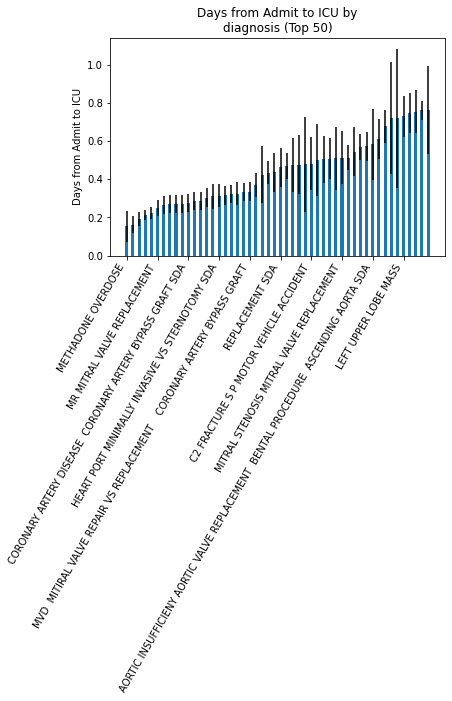

In [37]:
# sort by increasing mean days to icu, sample top 50 diagnoses with shortest mean time to ICU
diagnoses_array = np.array(top_diagnoses_list)
mn_daysto_icu_array = np.array(mn_daysto_icu)
sem_daysto_icu_array = np.array(sem_daysto_icu)

sorted_ix = np.argsort(mn_daysto_icu_array)
mn_daysto_icu_array = mn_daysto_icu_array[sorted_ix]
sem_daysto_icu_array = sem_daysto_icu_array[sorted_ix]
diagnoses_array = diagnoses_array[sorted_ix]

top50_mn_daysto_icu_array = mn_daysto_icu_array[0:50]
top50_sem_daysto_icu_array = sem_daysto_icu_array[0:50]
top50_diagnoses_array = diagnoses_array[0:50]

plt.bar(x=top50_diagnoses_array,
        height=top50_mn_daysto_icu_array,width=0.5,
       yerr=top50_sem_daysto_icu_array)
plt.title('Days from Admit to ICU by\ndiagnosis (Top 50)')
plt.ylabel('Days from Admit to ICU')
xlabels = top50_diagnoses_array
plt.xticks(range(0,len(xlabels),5),xlabels[0::5],rotation=60,ha='right')
top50_diagnoses_array[top50_mn_daysto_icu_array<=1]

This figure plots a summary of mean days to ICU stay by diagnosis. It is clear that certain diagnosis terms (e.g., those involving the heart or trauma) typically require near-immediate ICU stay, whereas others do not.

In the future, I would like to look at a regression model using the top X diagnoses as categorical variables to get a more analytical assessment of this relationship.

array([], dtype='<U120')

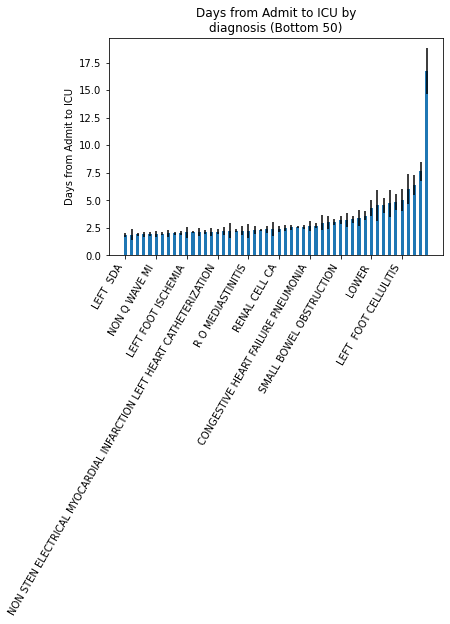

In [38]:
# now let's compare the 50 diagnoses with longest mean time to ICU
bottom50_mn_daysto_icu_array = mn_daysto_icu_array[-50:]
bottom50_sem_daysto_icu_array = sem_daysto_icu_array[-50:]
bottom50_diagnoses_array = diagnoses_array[-50:]

plt.bar(x=bottom50_diagnoses_array,
        height=bottom50_mn_daysto_icu_array,width=0.5,
       yerr=bottom50_sem_daysto_icu_array)
plt.title('Days from Admit to ICU by\ndiagnosis (Bottom 50)')
plt.ylabel('Days from Admit to ICU')
xlabels = bottom50_diagnoses_array
plt.xticks(range(0,len(xlabels),5),xlabels[0::5],rotation=60,ha='right')
bottom50_diagnoses_array[bottom50_mn_daysto_icu_array<=1]

array(['METHADONE OVERDOSE',
       'CORONARY ARTERY DISEASE CORONARY ARTERY BYPASS GRAFT  ASCENDING AORTA HEMI ARCH REPLACEMENT SDA',
       'ACUTE CORONARY DISEASE', 'MVR  SDA',
       'CORONARY ARTERY DISEASE  CORONARY ARTERY BYPASS GRAFT SDA',
       'CORONARY ARTERY BYPASS GRAFT     SDA',
       'CORONARY ARTERY DISEASE CORONARY ARTERY BYPASS GRAFT  MVR  SDA',
       'CHRONIC PERICARDIAL  REDO AORTIC ROOT ARCH REPLACEMENT SDA',
       'REDO',
       'MITRAL VALVE DISORDER CORONARY ARTERY BYPASS GRAFT WITH MVR REDO  REDO STERNOTOMY SDA',
       'CORONARY ARTERY DISEASE SDA CORONARY ARTERY BYPASS GRAFT',
       'CORONARY ARTERY DISEASE CORONARY ARTERY BYPASS GRAFT WITH MVR REDO',
       'AORTIC STENOSIS CORONARY ARTERY BYPASS GRAFT WITH AVR   MITRAL VALVE REPLACEMENT  SDA',
       'MITRAL VALVE INSUFFIECIENY CORONARY ARTERY BYPASS GRAFT WITH MVR  AORTIC VALVE REPLACEMENT  SDA',
       'MVD  MITIRAL VALVE REPAIR VS REPLACEMENT    CORONARY ARTERY BYPASS GRAFT',
       'CORONARY ARTERY

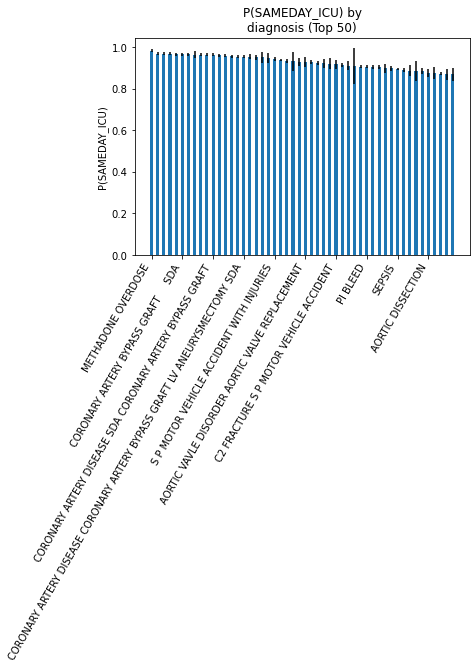

In [39]:
# now, let's do the same things as above but for P(SAMEDAY_ICU)
# first, the 50 with highest P(SAMEDAY_ICU)
diagnoses_array = np.array(top_diagnoses_list)
p_sameday_icu_array = np.array(p_sameday_icu)
sem_sameday_icu_array = np.array(sem_sameday_icu)

sorted_ix = np.argsort(-p_sameday_icu_array)
p_sameday_icu_array = p_sameday_icu_array[sorted_ix]
sem_sameday_icu_array = sem_sameday_icu_array[sorted_ix]
diagnoses_array = diagnoses_array[sorted_ix]

top50_p_sameday_icu_array = p_sameday_icu_array[0:50]
top50_sem_sameday_icu_array = sem_sameday_icu_array[0:50]
top50_diagnoses_array = diagnoses_array[0:50]

plt.bar(x=top50_diagnoses_array,
        height=top50_p_sameday_icu_array,width=0.5,
       yerr=top50_sem_sameday_icu_array)
plt.title('P(SAMEDAY_ICU) by\ndiagnosis (Top 50)')
plt.ylabel('P(SAMEDAY_ICU)')
xlabels = top50_diagnoses_array
plt.xticks(range(0,len(xlabels),5),xlabels[0::5],rotation=60,ha='right')
top50_diagnoses_array[top50_p_sameday_icu_array>=0.5]

Similarly, figure plots the probability that a particular diagnosis term is associated with an ICU day within 24 hours of admittance. Again, certain terms related to the heart, brain, and lungs have >= 50% likelihood of a same-day ICU admittance. 

(array(['BENTAL PROCEDURE',
        'LEFT VENTRICULAR LEAD CAUSING DIAPHRAGMATIC STIMULATION S P ICD IMPLANT LEFT VENTRICULAR LEAD REVISION REMOTE WEST  SDA',
        'RENAL FAILURE KIDNEY TRANSPLANT', 'OBSTRUCTION',
        'CONGESTIVE HEART FAILURE', 'WOUND INFECTION OF LEFT TIBIA SDA',
        'CONGESTIVE HEART FAILURE PNEUMONIA',
        'CONGESTIVE HEART FAILURE R O MYOCARDIAL INFARCTION',
        'MITRAL STENOSIS RIGHT AND LEFT HEART CATH',
        'LEUKEMIA VS LYMPHOMA',
        'CORONARY ARTERY DISEASE CONGESTIVE HEART FAILURE', 'MASS',
        'MVR SDA', 'MITRAL VALVE REGURGITATION MITRAL VALVE REPLACEMENT',
        'PNEUMONIA CONGESTIVE HEART FAILURE NSTEMI',
        'STENT NON FUNCTION BRONCHOSCOPY RIGID', 'UNSTABLE ANGINA CATH',
        'BRAIN MASS', 'CHEST PAIN CATH', 'COLON TUMOR SDA',
        'SMALL BOWEL OBSTRUCTION', 'R O MI', 'TUMOR',
        'LEFT HUMERUS FRACTURE', 'LEFT  SDA', 'RIGHT HIP OA SDA',
        'TVR RIGHT CHEST BEATING HEART SDA', 'LEFT', 'LEFT SDA',
    

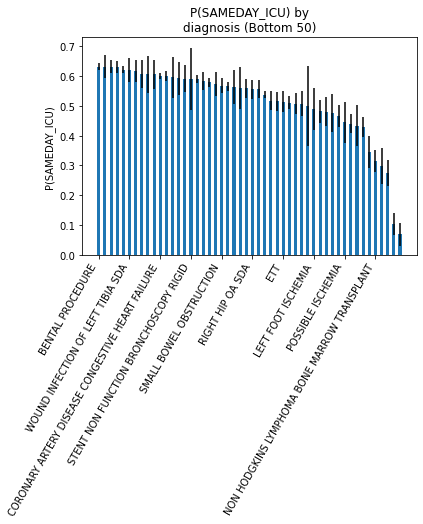

In [40]:
# next, the 50 with lowest P(SAMEDAY_ICU)
bottom50_p_sameday_icu_array = p_sameday_icu_array[-50:]
bottom50_sem_sameday_icu_array = sem_sameday_icu_array[-50:]
bottom50_diagnoses_array = diagnoses_array[-50:]

plt.bar(x=bottom50_diagnoses_array,
        height=bottom50_p_sameday_icu_array,width=0.5,
       yerr=bottom50_sem_sameday_icu_array)
plt.title('P(SAMEDAY_ICU) by\ndiagnosis (Bottom 50)')
plt.ylabel('P(SAMEDAY_ICU)')
xlabels = bottom50_diagnoses_array
plt.xticks(range(0,len(xlabels),5),xlabels[0::5],rotation=60,ha='right')
bottom50_diagnoses_array[bottom50_p_sameday_icu_array>=0.5],bottom50_diagnoses_array[bottom50_p_sameday_icu_array<0.5]

In [41]:
# clean up some columns before using pairplot
# first, fill nans
values = {'RELIGION': 'NOT SPECIFIED', 'LANGUAGE': '***','MARITAL_STATUS': 'UNKNOWN (DEFAULT)', 'ETHNICITY': 'UNKNOWN',
          'INSURANCE': 'Not Specified', 'ADMISSION_LOCATION': '** INFO NOT AVAILABLE **', 'ADMISSION_TYPE': 'UNKNOWN'}
df_patient_admit_icu.fillna(value=values, inplace=True)

# next, replace redundant fields
df_patient_admit_icu['RELIGION'] = df_patient_admit_icu['RELIGION'].str.replace('UNOBTAINABLE','NOT SPECIFIED')
df_patient_admit_icu = df_patient_admit_icu.drop(['HOSPITAL_DAYS','D_IN_DIAGNOSIS'],axis=1)

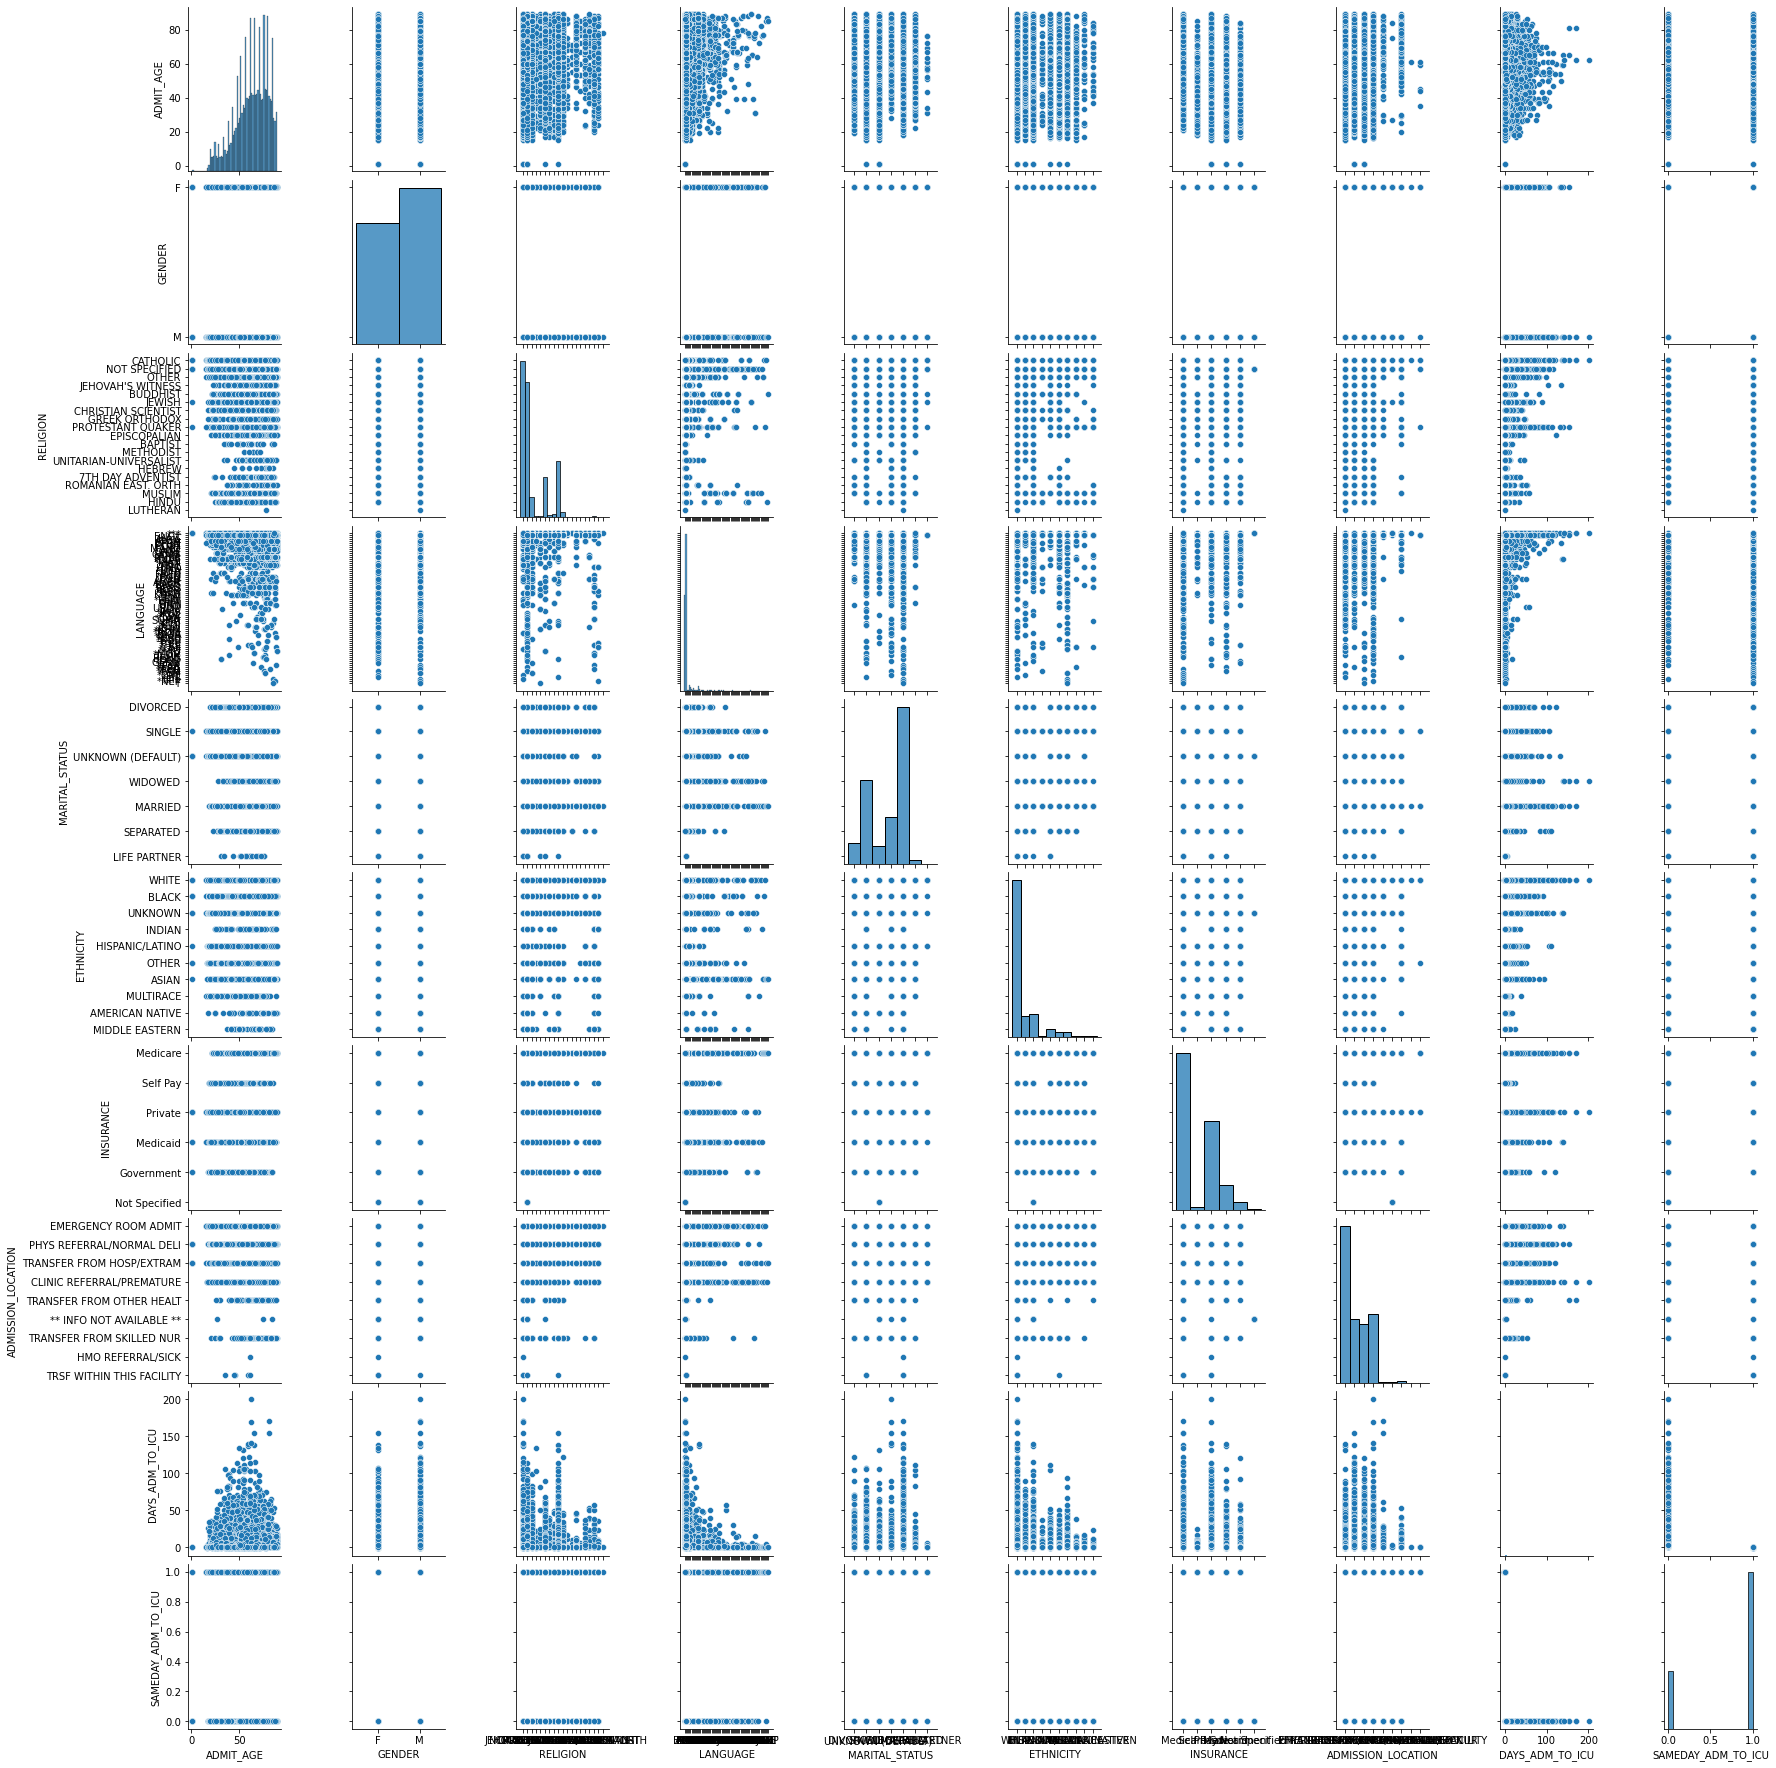

In [42]:
# a. pairplot of df_patient_admitunique
#astype's now look at a bunch of other features and their relationship to DAYS_ADM_TO_ICU or SAMEDAY_ADM_TO_ICU
import seaborn as sns
import matplotlib.pyplot as plt
variables = ['ADMIT_AGE','GENDER','RELIGION','LANGUAGE','MARITAL_STATUS','ETHNICITY','INSURANCE','ADMISSION_LOCATION','DAYS_ADM_TO_ICU','SAMEDAY_ADM_TO_ICU']
sns.pairplot(df_patient_admit_icu,vars = variables)
plt.show()

The above figure looks at a number of other features to see their relationship to either days to ICU stay or SAMEDAY_ADM_TO_ICU. From the plot, it appears that:
1. there appears to be a weak correlation between age and time to ICU
2. females are transferred faster to the ICU compared to males
3. there may be correlations with language, marital status, ethinicity, insurance, admission location and days to icu

I will look into some of these in more detail below.

(39888, 13471)

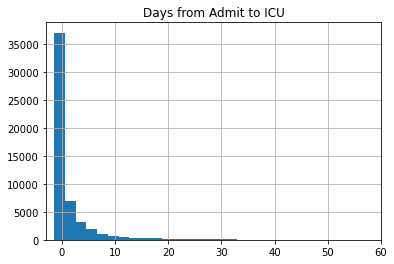

In [43]:
df_patient_admit_icu['DAYS_ADM_TO_ICU'].hist(bins=100)
plt.xlim([-3, 60])
plt.title('Days from Admit to ICU')
sum(df_patient_admit_icu['DAYS_ADM_TO_ICU']<=1),sum(df_patient_admit_icu['DAYS_ADM_TO_ICU']>1)

This figure shows the distribution of days from admission to ICU stay. We can see that the distribution is heavily skewed right, and there are ~47.5K entries where the time from hospital admission to ICU stay is <=1 day, and perhaps ~15K entries where time from hospital admission to ICU stay is >1 day. I am looking to identify features that predict when times will be <1 day and/or what features discriminate between times <=1 day and times >1day.

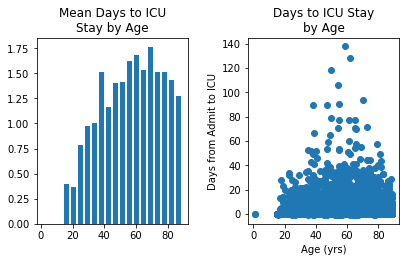

In [44]:
# look at the relationship between age and time between hospital admission and ICU stay

from scipy.stats import binned_statistic
from matplotlib.pyplot import bar
from numpy import nanmean

sbj_cnt_icu_ttl = df_patient_admit_icu.groupby(['SUBJECT_ID']).agg({'SUBJECT_ID' : ['count'], 'DAYS_ADM_TO_ICU' : [nanmean], 'ADMIT_AGE' : [nanmean]})

# drop nan
sbj_cnt_icu_ttl.dropna(subset=[('ADMIT_AGE','nanmean')],inplace=True)
# drop nan from sbj_cnt_icu_ttl[('DAYS_ADM_TO_ICU','nanmean')] (likely because all grouped data were NaN)
sbj_cnt_icu_ttl = sbj_cnt_icu_ttl[sbj_cnt_icu_ttl[('DAYS_ADM_TO_ICU','nanmean')].notna()]

# find mean ICU days based on bins of ADMIT_AGE
bin_means, bin_edges, binnumber = binned_statistic(sbj_cnt_icu_ttl[('ADMIT_AGE','nanmean')],sbj_cnt_icu_ttl[('DAYS_ADM_TO_ICU','nanmean')],bins=20)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

figure, _ = plt.subplots(nrows=1, ncols=2)
ax = plt.subplot(1,2,1)
bar(bin_centers, bin_means,width=3)
plt.title('Mean Days to ICU\nStay by Age')

plt.subplot(1,2,2)
plt.plot(sbj_cnt_icu_ttl[('ADMIT_AGE','nanmean')],sbj_cnt_icu_ttl[('DAYS_ADM_TO_ICU','nanmean')],'o')
plt.title('Days to ICU Stay\nby Age')
plt.xlabel('Age (yrs)')
plt.ylabel('Days from Admit to ICU')
figure.tight_layout(pad=2.0)

This figure shows the relationship between age at time of hospital admission and the days between hospital admission and ICU stay. From the plots, there appears to be a slight relationship between age and time to ICU stay, with younger patients more likely to require faster transfers to the ICU.

In [45]:
sbj_cnt_icu_ttl.corr()

,,SUBJECT_ID,DAYS_ADM_TO_ICU,ADMIT_AGE
,,count,nanmean,nanmean
SUBJECT_ID,count,1.000000,0.183840,0.011486
DAYS_ADM_TO_ICU,nanmean,0.183840,1.000000,0.035158
ADMIT_AGE,nanmean,0.011486,0.035158,1.000000


In [46]:
from scipy.stats import pearsonr
corr_stats = pearsonr(y=sbj_cnt_icu_ttl[('DAYS_ADM_TO_ICU','nanmean')], x=sbj_cnt_icu_ttl[('ADMIT_AGE','nanmean')])
corr_stats

(0.03515842439858894, 1.7668212653676297e-11)

Above, I calculate the correlation between age and days to ICU transfer. As we can see, there is a small correlation between admit age and ICU transfer. Given the size of the dataset, this is highly significant (p=1.7E-11).

In [47]:
# relationship between sex and days to ICU
from scipy.stats import ttest_ind, ranksums

cat1 = df_patient_admit_icu[df_patient_admit_icu['GENDER']=='F']
cat2 = df_patient_admit_icu[df_patient_admit_icu['GENDER']=='M']
gndr_daysToICU = ttest_ind(cat1['DAYS_ADM_TO_ICU'], cat2['DAYS_ADM_TO_ICU'],nan_policy='omit')

# relationship between sex and P(sameday)
cat1 = df_patient_admit_icu[df_patient_admit_icu['GENDER']=='F']
cat2 = df_patient_admit_icu[df_patient_admit_icu['GENDER']=='M']
gndr_probSameDayICU = ranksums(cat1['SAMEDAY_ADM_TO_ICU'], cat2['SAMEDAY_ADM_TO_ICU'])

(gndr_daysToICU, gndr_probSameDayICU)

(Ttest_indResult(statistic=-1.5543060692337152, pvalue=0.1201173574774172),
 RanksumsResult(statistic=0.5686934596235127, pvalue=0.5695641871118133))

From the above analysis, we see that the relationship between gender and days from admit to ICU only trends towards significance (p=0.12), with females having slightly shorter mean times. There is no significant relationship between gender and the probability of having a same-day ICU admission.

In [48]:
# relationship between insurance type and days to ICU stay
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kruskal

mod = ols('DAYS_ADM_TO_ICU ~ C(INSURANCE)', data = df_patient_admit_icu).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)

# relationship between insurance type and P(sameday)
krus_table = kruskal(*[group['SAMEDAY_ADM_TO_ICU'].values for name, group in df_patient_admit_icu.groupby('INSURANCE')])

(aov_table, krus_table)

/Users/adamgifford/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


(                    sum_sq       df         F        PR(>F)
 C(INSURANCE)  2.005736e+03      5.0  9.890065  5.371843e-08
 Residual      2.164071e+06  53354.0       NaN           NaN,
 KruskalResult(statistic=486.2562413888016, pvalue=7.389108232656125e-103))

ANOVA results show that there is a significant effect of INSURANCE type on days from hospital admission to ICU stay (p=5.4E-8).

In [49]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

X = df_patient_admit_icu['INSURANCE']
y = df_patient_admit_icu['SAMEDAY_ADM_TO_ICU']

X = pd.get_dummies(X, prefix='INSURANCE')
X = X.drop(['INSURANCE_Not Specified'],axis=1)

# define pipeline
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', LogisticRegression(class_weight='balanced',penalty='l1',solver='saga'))]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
score = np.mean(scores)
print(score)

0.5396429299957167


Using a simple cross-validated logistic regression model on the relationship between INSURANCE and SAMEDAY_ADM_TO_ICU, we see a small predictive effect, with an average ROC AUC of 0.54.

In [50]:
df_patient_admit_icu['ETHNICITY'].unique()

array(['WHITE', 'BLACK', 'UNKNOWN', 'INDIAN', 'HISPANIC/LATINO', 'OTHER',
       'ASIAN', 'MULTIRACE', 'AMERICAN NATIVE', 'MIDDLE EASTERN'],
      dtype=object)

In [51]:
# looking at all but DIAGNOSIS here since that is currently a list of diagnosis terms for each row, 
# too complicated to modify right now for simple logistic regression
X = df_patient_admit_icu.iloc[:,[1,4,5,6,7,8,9,10,13]]
y = df_patient_admit_icu['SAMEDAY_ADM_TO_ICU']

X = pd.get_dummies(X, prefix=['GDR','TYP','LOC','INS','LNG','REL','MS','ETH'])
X = X.drop(['GDR_F','TYP_UNKNOWN','LOC_** INFO NOT AVAILABLE **','INS_Not Specified','LNG_***','REL_NOT SPECIFIED','MS_UNKNOWN (DEFAULT)','ETH_UNKNOWN'],axis=1)
X.fillna(X.mean(), inplace=True)

# define pipeline
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.75)
steps = [('over', over), ('under', under), ('model', LogisticRegression(class_weight='balanced',penalty='l1',solver='saga'))]
# steps = [('over', over), ('model', LogisticRegression(class_weight='balanced',penalty='l1',solver='saga'))]
# steps = [('under', under), ('model', LogisticRegression(class_weight='balanced',penalty='l1',solver='saga'))]
# steps = [('model', LogisticRegression(class_weight='balanced',penalty='l1',solver='saga'))]

pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X.values, y, scoring='roc_auc', cv=cv, n_jobs=-1)
score = np.mean(scores)
print(score)

0.618702803897699


Now using all of the features in the dataset thus far (except DIAGNOSIS), we can achieve an ROC AUC of 0.62 using a simple logistic regression.

In [52]:
# 4. Load prescriptions
# import prescriptions info
prescrips_file = 'PRESCRIPTIONS.csv'
df_prescrips = pd.read_csv(data_dir + prescrips_file,low_memory=False)

df_prescrips = df_prescrips.drop(['ROW_ID','GSN','DRUG','DRUG_NAME_POE','DRUG_NAME_GENERIC','FORMULARY_DRUG_CD','ENDDATE','DRUG_TYPE','ROUTE','PROD_STRENGTH', 'DOSE_VAL_RX', 'DOSE_UNIT_RX','FORM_VAL_DISP', 'FORM_UNIT_DISP'],axis=1)
df_prescrips.STARTDATE = pd.to_datetime(df_prescrips.STARTDATE,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

ndc_nan_idx = df_prescrips[df_prescrips['NDC'].isna()].index
df_prescrips=df_prescrips.drop(ndc_nan_idx,axis=0)

# using NDC code for drug identity rather than drug names since working with numerics is easier
df_prescrips['NDC'] = df_prescrips['NDC'].astype('int64')

In [53]:
child_idx = df_prescrips[df_prescrips['SUBJECT_ID'].isin(child_patients)].index
df_prescrips = df_prescrips.drop(child_idx,axis=0)

In [54]:
# merge datasets
df_patient_admit_icu_prescrip = df_patient_admit_icu.merge(df_prescrips,how='left',left_on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],right_on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])

Now I want to calculate the time between when a drug was prescribed (proxy for time a drug was taken) and transfer to the ICU, under the hypothesis that perhaps certain drugs (or combinations of drugs) are predictive of an imminent need for ICU care.

In [55]:
# calculate days from hospital admission to drug prescription
df_patient_admit_icu_prescrip['DAYS_ADM_TO_DRUG'] = (df_patient_admit_icu_prescrip['STARTDATE'] - df_patient_admit_icu_prescrip['ADMITTIME']).dt.total_seconds()/(24*60*60)

# drop time columns no longer needed
df_patient_admit_icu_prescrip = df_patient_admit_icu_prescrip.drop(['STARTDATE','ADMITTIME'],axis=1)

In [56]:
# calculate time of drug prescription relative to ICU stay (<0 means ICU stay comes before drug prescription)
df_patient_admit_icu_prescrip['DAYS_DRUG_BEFORE_ICU'] = df_patient_admit_icu_prescrip['DAYS_ADM_TO_ICU'] - df_patient_admit_icu_prescrip['DAYS_ADM_TO_DRUG']

In [62]:
# keep only rows where drugs were prescribed prior to ICU stay
df_patient_admit_icu_prescrip_drugsfirst = df_patient_admit_icu_prescrip[df_patient_admit_icu_prescrip['DAYS_DRUG_BEFORE_ICU']>0]

In [63]:
# for each subject, hospital admission, and associated icu stay: determine the number and list of drugs prescribed and mean times
from numpy import nansum, nanmean
prescrips_by_combo_before_icu = df_patient_admit_icu_prescrip_drugsfirst.groupby(['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).agg({'NDC': ['count', list],'DAYS_ADM_TO_ICU': [nanmean],'DAYS_ADM_TO_DRUG': [nanmean],'DAYS_DRUG_BEFORE_ICU': [nanmean]})

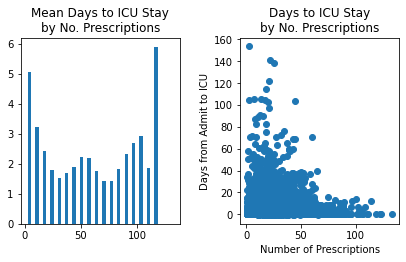

In [64]:
# now let's look at the relationship between number of prescriptions for a patient and days to ICU stay

# binned days to ICU stay by number of prescriptions
bin_means, bin_edges, binnumber = binned_statistic(prescrips_by_combo_before_icu[('NDC','count')],prescrips_by_combo_before_icu[('DAYS_ADM_TO_ICU','nanmean')],bins=20)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

figure, _ = plt.subplots(nrows=1, ncols=2)
ax = plt.subplot(1,2,1)
bar(bin_centers, bin_means,width=3)
plt.title('Mean Days to ICU Stay\nby No. Prescriptions')

plt.subplot(1,2,2)
plt.plot(prescrips_by_combo_before_icu[('NDC','count')],prescrips_by_combo_before_icu[('DAYS_ADM_TO_ICU','nanmean')],'o')
plt.title('Days to ICU Stay\nby No. Prescriptions')
plt.xlabel('Number of Prescriptions')
plt.ylabel('Days from Admit to ICU')
figure.tight_layout(pad=2.0)

This figure shows the relationship between number of prescriptions and time from hospital admission to ICU stay. It appears there is a weak relationship, with more prescriptions being associated with a slightly shorter time to ICU transfer.

In [65]:
prescrips_by_combo_before_icu.corr()

,,NDC,DAYS_ADM_TO_ICU,DAYS_ADM_TO_DRUG,DAYS_DRUG_BEFORE_ICU
,,count,nanmean,nanmean,nanmean
NDC,count,1.000000,-0.068933,-0.072343,0.136751
DAYS_ADM_TO_ICU,nanmean,-0.068933,1.000000,0.999707,0.067229
DAYS_ADM_TO_DRUG,nanmean,-0.072343,0.999707,1.000000,0.043058
DAYS_DRUG_BEFORE_ICU,nanmean,0.136751,0.067229,0.043058,1.000000


This is confirmed with the small, negative correlation value of -0.07. (Unsurprisingly, there seems to be a positive correlation between number of drugs and days drugs were prescribed prior to ICU transfer. This may be related to the fact that more drugs can be prescribed during longer stays between hospital admission and ICU stay.)